In [1]:
import cv2
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [2]:
#Reading video files
left_camera = cv2.VideoCapture('robot-navigation-video/RobotL.avi')
right_camera = cv2.VideoCapture('robot-navigation-video/RobotR.avi')

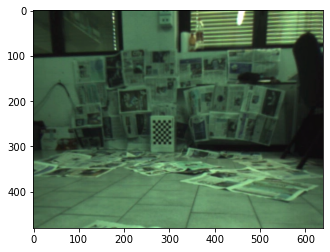

In [3]:
#Getting a couple of frames from the two videos
if left_camera.isOpened():
    left_ret, left_frame = left_camera.read()
if right_camera.isOpened():
    right_ret, right_frame = right_camera.read()
plt.imshow(left_frame)
plt.show()

#### 1. Computing the disparity map in a central area of the reference frame (e.g. a squared area of size 60x60, 80x80 o 100x100 pixels), so to sense distances in the portion of the environment which would be travelled by the vehicle should it keep a straight trajectory.

For each pair of candidate corresponding points, the basic stereo matching algorithm consists in comparing the intensities belonging to two squared windows centred at the points. Such a comparison involves computation of either a dissimilarity (e.g. SAD, SSD) or similarity (e.g. NCC, ZNCC) measure between the two windows. 

As the matching process is carried out on rectified images, once a reference image is chosen (e.g. the left view), the candidates associated with a given point need to be sought for along the same row in the other image (right view) only and, usually, within a certain disparity range which depends on the depth range one wishes to sense. 

Accordingly, given a point in the reference image, the corresponding one in the other image is selected as the candidate minimizing (maximizing) the chosen dissimilarity (similarity) measure between the windows. As such, the parameters of the basic stereo matching algorithm consist in the size of the window and the disparity range. In this project, students should choose the former properly, while the latter is fixed to the interval [0, 128].

We decide to use SAD to prioritize speed. Indeed, while NCC is more robust to light changes, since the setting of a stereo vision problem provides the same lighting across the two images, there is no need to use a more computationally heavy method.

In [4]:
def sad(window_left, window_right):
    return np.sum(np.abs(np.float32(window_left) - np.float32(window_right)))

In [5]:
def compute_disparity_map(left_frame, right_frame, squared_area, window_size, disparity_range):
    window_shapes = window_size//2
    height, width, _ = left_frame.shape
    left_frame = np.array(left_frame, np.float32)
    right_frame = np.array(right_frame, np.float32)
    disparity_map = np.zeros((height, width), dtype=int)

    y_min = height//2 - squared_area//2
    y_max = height//2 + squared_area//2
    x_min = width//2 - squared_area//2
    x_max = width//2 + squared_area//2

    for y in range(y_min, y_max):
        for x in range(x_min, x_max):
            sad_list = []
            left_pixels = left_frame[y-window_shapes:y+window_shapes, x-window_shapes:x+window_shapes]
            for d in disparity_range:
                right_pixels = right_frame[y-window_shapes:y+window_shapes, x-window_shapes-d:x+window_shapes-d]
                value = sad(left_pixels, right_pixels)
                sad_list.append(value)
            best_d = np.argmin(sad_list)
            disparity_map[y,x] = best_d
    return disparity_map, y_min, y_max, x_min, x_max

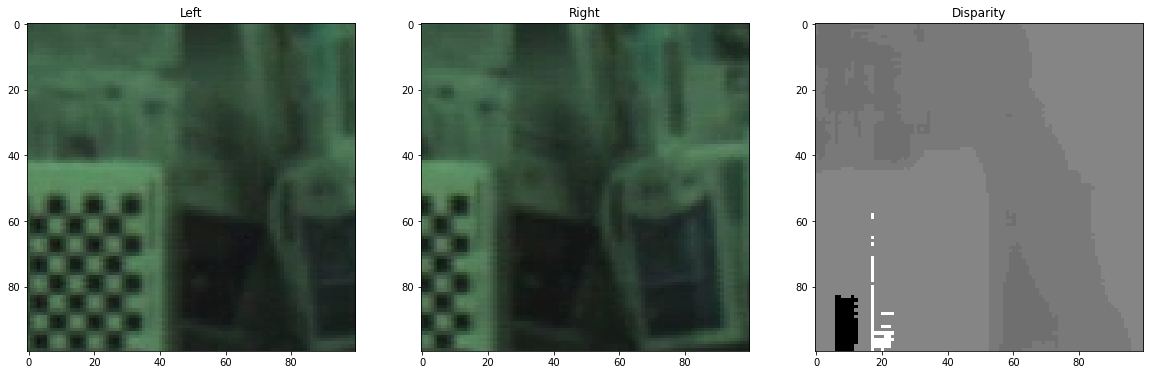

In [6]:
squared_area = 100
window_size = 20
disparity_range = range(0,128)
disparity_map, y_min, y_max, x_min, x_max = compute_disparity_map(left_frame, right_frame, squared_area, window_size, disparity_range)
disparity_map = disparity_map[y_min:y_max, x_min:x_max]
plt.figure(figsize=(20,20))
plt.subplot(1,3,1)
plt.title("Left")
plt.imshow(left_frame[y_min:y_max, x_min:x_max]/255, "gray")
plt.subplot(1,3,2)
plt.title("Right")
plt.imshow(right_frame[y_min:y_max, x_min:x_max]/255, "gray")
plt.subplot(1,3,3)
plt.title("Disparity")
plt.imshow(disparity_map, "gray")

#### 2. Estimate a main disparity (dmain) for the frontal (wrt the camera) portion of the environment based on the disparity map of the central area of the reference frame computed in the previous step, e.g. by choosing the average disparity or the most frequent disparity within the map.

In [7]:
def maindisparity(disparity_map):
    #Compute average disparity
    return sum(map(sum, disparity_map))/sum(map(len,disparity_map))

dmain = maindisparity(disparity_map)
print(f"Average disparity: {dmain}")

Average disparity: 19.3383


In [8]:
def most_frequent_disparity(disparity_map):
    histogram = {}  
    for y in range(0, disparity_map.shape[1]):
        for x in range(0, disparity_map.shape[0]):
            disp = disparity_map[y,x]
            if disp in histogram:
                histogram[disp] += 1 
            else:
                histogram[disp] = 1 

    most_frequent = max(histogram, key = histogram.get) 
    return most_frequent

mfdmain = most_frequent_disparity(disparity_map)
print(f"Most frequent disparity: {mfdmain}")

Most frequent disparity: 20


#### 3. Determine the distance (z, in mm) of the obstacle wrt to the moving vehicle based on the main disparities (in pixel) estimated from each pair of frames

In [9]:
def compute_distance(b, f, dmain):
    return (b*f)/dmain

f = 567.2 
b = 92.226
z = compute_distance(b, f, maindisparity(disparity_map))
print(f"Distance (mm): {z}")

Distance (mm): 2705.025115961589


#### 4. Generate a suitable output to convey to the user, in each pair of frame, the information related to the distance (converted in meters) from the camera to the obstacle. Moreover, an alarm should be generated whenever the distance turns out below 0.8 meters.

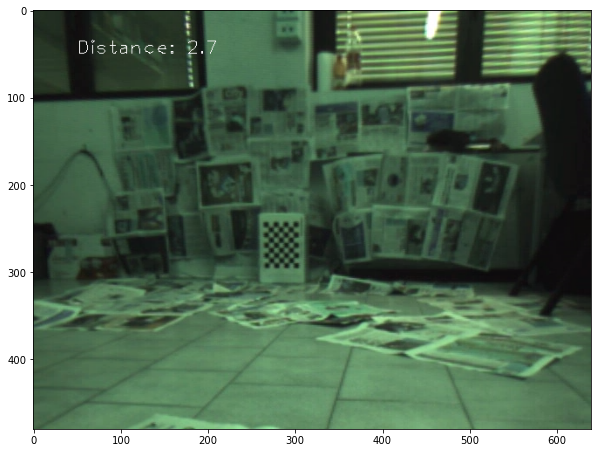

In [10]:
position = (50,50)
cv2.putText(left_frame,f"Distance: {(z/1000):.1f}",position, cv2.FONT_HERSHEY_PLAIN, color = (255, 255, 255), fontScale = 1.5)
if((z/1000) < 0.8):
    cv2.putText(left_frame,f"ALERT",(50,90), cv2.FONT_HERSHEY_PLAIN, color = (255, 0, 0), fontScale = 2.5, thickness = 2)

plt.figure(figsize=(10, 10))
plt.imshow(left_frame)
plt.show()

#### 5. Compute the real dimensions in mm (W,H) of the chessboard pattern present in the scene.

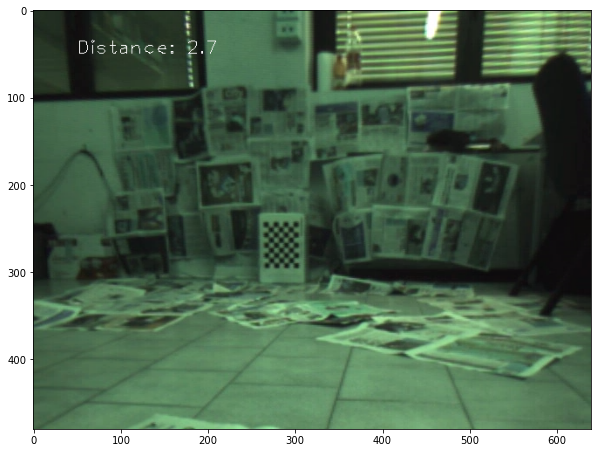

In [11]:
patternSize = (6,8)
chess_frame = left_frame.copy()

def find_chessboard_corners(chess_frame):
    #The function returns a non-zero value if all of the corners are found and they are placed in a certain order 
    #(row by row, left to right in every row)
    retval, corners = cv2.findChessboardCorners(chess_frame, patternSize)
    if(retval):
        gray_frame = cv2.cvtColor(chess_frame, cv2.COLOR_BGR2GRAY)
        # Criteria for termination of the iterative process of corner refinement. 
        # The process of corner position refinement stops either after criteria.maxCount iterations 
        # or when the corner position moves by less than criteria.epsilon on some iteration
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_COUNT, 30, 1)
        corners2 = cv2.cornerSubPix(gray_frame, corners, (5,5),(-1,-1), criteria) 
        cv2.drawChessboardCorners(chess_frame, patternSize, corners2, retval)
        return chess_frame,corners2
    else:
        return chess_frame, []

final_image, corners2 = find_chessboard_corners(chess_frame)
plt.figure(figsize=(10, 10))
plt.imshow(final_image)
plt.show()


In [12]:
def estimate_hw(corners2):
    if(len(corners2)!=0):
        top_left = tuple(corners2[0,0,:])
        top_right = tuple(corners2[(patternSize[0]-1),0,:])
        bottom_left = tuple(corners2[(patternSize[0]*patternSize[1] - patternSize[0]),0,:])
        bottom_right = tuple(corners2[(patternSize[0]*patternSize[1] -1),0,:])

        W = z * np.linalg.norm(top_right[0] - top_left[0]) / f
        H = z * np.linalg.norm((bottom_right[1] - top_right[1])) / f
        
        return W,H
    else:
        return 0,0
        
        
W, H = estimate_hw(corners2)
if(W == 0 and H == 0):
    print('No corners detected')
else:
    print(f'Estimated width: {W:.2f}, real: 125')
    print(f'Estimated height: {H:.2f}, real: 178')


No corners detected


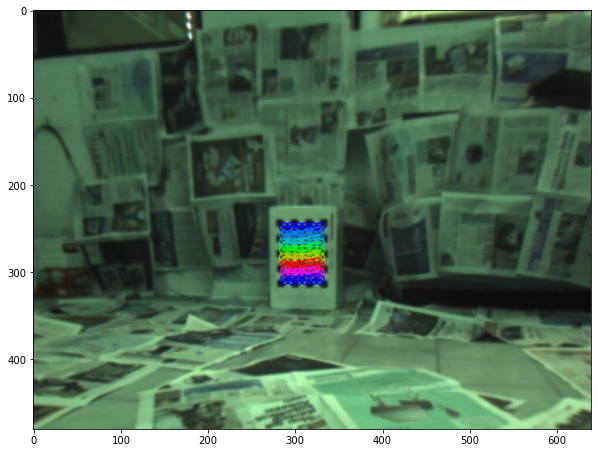

In [17]:
from IPython.display import clear_output

def play_video():
    try:
        while(left_camera.isOpened() and right_camera.isOpened()):
            left_ret, left_frame = left_camera.read()
            right_ret, right_frame = right_camera.read()   
            if not left_ret or left_frame is None:
                left_camera.release()
                break
            
            final_image, corners2 = find_chessboard_corners(left_frame)
            plt.figure(figsize=(10, 10))
            plt.imshow(left_frame)
            plt.show()

            clear_output(wait=True)
    except KeyboardInterrupt:
        cap.release()
        print("released video resource")

play_video()

#### 6. Modify the matching algorithm so to deploy a smaller disparity range, such as e.g. [0+o, 64+o], with o being a suitable horizontal offset. This offset can be computed as that value allowing the main disparity, dmain, computed at the previous time instant to lie at the centre of the disparity range. Accordingly, as the vehicle gets closer to the obstacle, the horizontal offset increases, thus avoiding the main disparity to exceed the disparity range (and conversely, when the vehicle goes away from the obstacle).

In [15]:
INF_LIMIT = 0
SUP_LIMIT = 64

def new_disparity(o):
    mean_value = (SUP_LIMIT - INF_LIMIT)/2
    if(o < mean_value):
        return range(INF_LIMIT, SUP_LIMIT)
    else:
        return range(o - mean_value, o+mean_value)

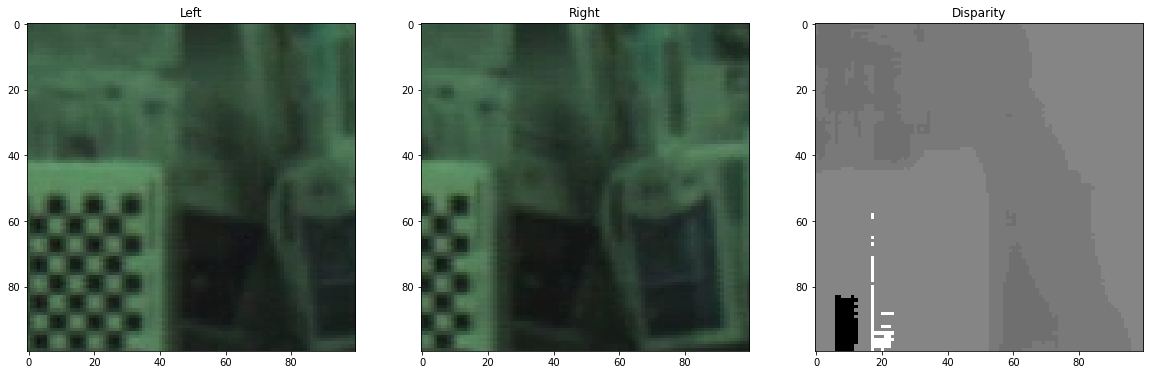

In [16]:
disparity_range = new_disparity(int(dmain))
disparity_map, y_min, y_max, x_min, x_max = compute_disparity_map(left_frame, right_frame, squared_area, window_size, disparity_range)
disparity_map = disparity_map[y_min:y_max, x_min:x_max]
plt.figure(figsize=(20,20))
plt.subplot(1,3,1)
plt.title("Left")
plt.imshow(left_frame[y_min:y_max, x_min:x_max]/255, "gray")
plt.subplot(1,3,2)
plt.title("Right")
plt.imshow(right_frame[y_min:y_max, x_min:x_max]/255, "gray")
plt.subplot(1,3,3)
plt.title("Disparity")
plt.imshow(disparity_map, "gray")